# Задача

Аналогично задаче на красное вино, только здесь здесь датасет белого вина

В этой задаче для обучения будут использовать 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

# Решение

In [1]:
# База
RANDOM_STATE = 43
import pandas as pd
import numpy as np
import sklearn as skl

# Препроцессинг данных
from sklearn.preprocessing import StandardScaler # Препроцессинг данных

# Трансформация данных
from sklearn.decomposition import PCA

# Вспомогательные классы/функции
from sklearn.model_selection import GridSearchCV # для поиска оптимальных гиперпараметров
from sklearn.model_selection import StratifiedKFold # для лучшего контроля кросс-валидации
from sklearn.metrics import classification_report # для быстрого просмотра оценок моделей
from sklearn.metrics import accuracy_score,confusion_matrix # для функции plot_confusionmatrix
from sklearn.base import clone # for model cloning
from sklearn import tree # для демонстрации: как устроено дерево

# Ключевые модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns # for data representation (kinda)
import scikitplot as skplt
from scikitplot.metrics import plot_roc # for roc curve

## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения. Удалите из выборки все объекты с пропусками и дубликаты.
2. Выделите 70% выборки для обучения и дальнейшего анализа.
3. Проанализируйте признаки и по необходимости предобработайте их. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную (НЕ забудьте удалить ее из датасета, когда будете обучать модель).

In [2]:
dataset_pd = pd.read_csv('winequality-white.csv', delimiter=';')
dataset_pd.head(10)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   
5            8.1              0.28         0.40             6.9      0.050   
6            6.2              0.32         0.16             7.0      0.045   
7            7.0              0.27         0.36            20.7      0.045   
8            6.3              0.30         0.34             1.6      0.049   
9            8.1              0.22         0.43             1.5      0.044   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   
5                 30.0                  97.0   0.9951  3.26       0.44   
6                 30.0                 136.0   0.9949  3.18       0.47   
7                 45.0                 170.0   1.0010  3.00       0.45   
8                 14.0                 132.0   0.9940  3.30       0.49   
9                 28.0                 129.0   0.9938  3.22       0.45   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6  
5     10.1        6  
6      9.6        6  
7      8.8        6  
8      9.5        6  
9     11.0        6

In [3]:
dataset_pd.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

In [4]:
dataset_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Проверим есть ли пропуски данных:

In [5]:
dataset_pd.isnull().sum().sum()

0

Проверим есть ли дубликаты данных:

In [6]:
dataset_drop_dup = dataset_pd.drop_duplicates(inplace=False)
print("Dataset shape before .drop_duplicates method:", dataset_pd.shape)
print("Dataset shape after .drop_duplicates method:", dataset_drop_dup.shape)

Dataset shape before .drop_duplicates method: (4898, 12)
Dataset shape after .drop_duplicates method: (3961, 12)


In [7]:
# Обнаружены дубликаты данных, поэтому далее работаем с уникальным датасетом:
dataset_pd.drop_duplicates(inplace=True)
print("Dataset shape after .drop_duplicates method:", dataset_pd.shape)

Dataset shape after .drop_duplicates method: (3961, 12)


Посмотрим распределение фичей оносительно друг друга: может некоторые из них окажутся скореллированными. Для начала построим попарное распределение фичей.

c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

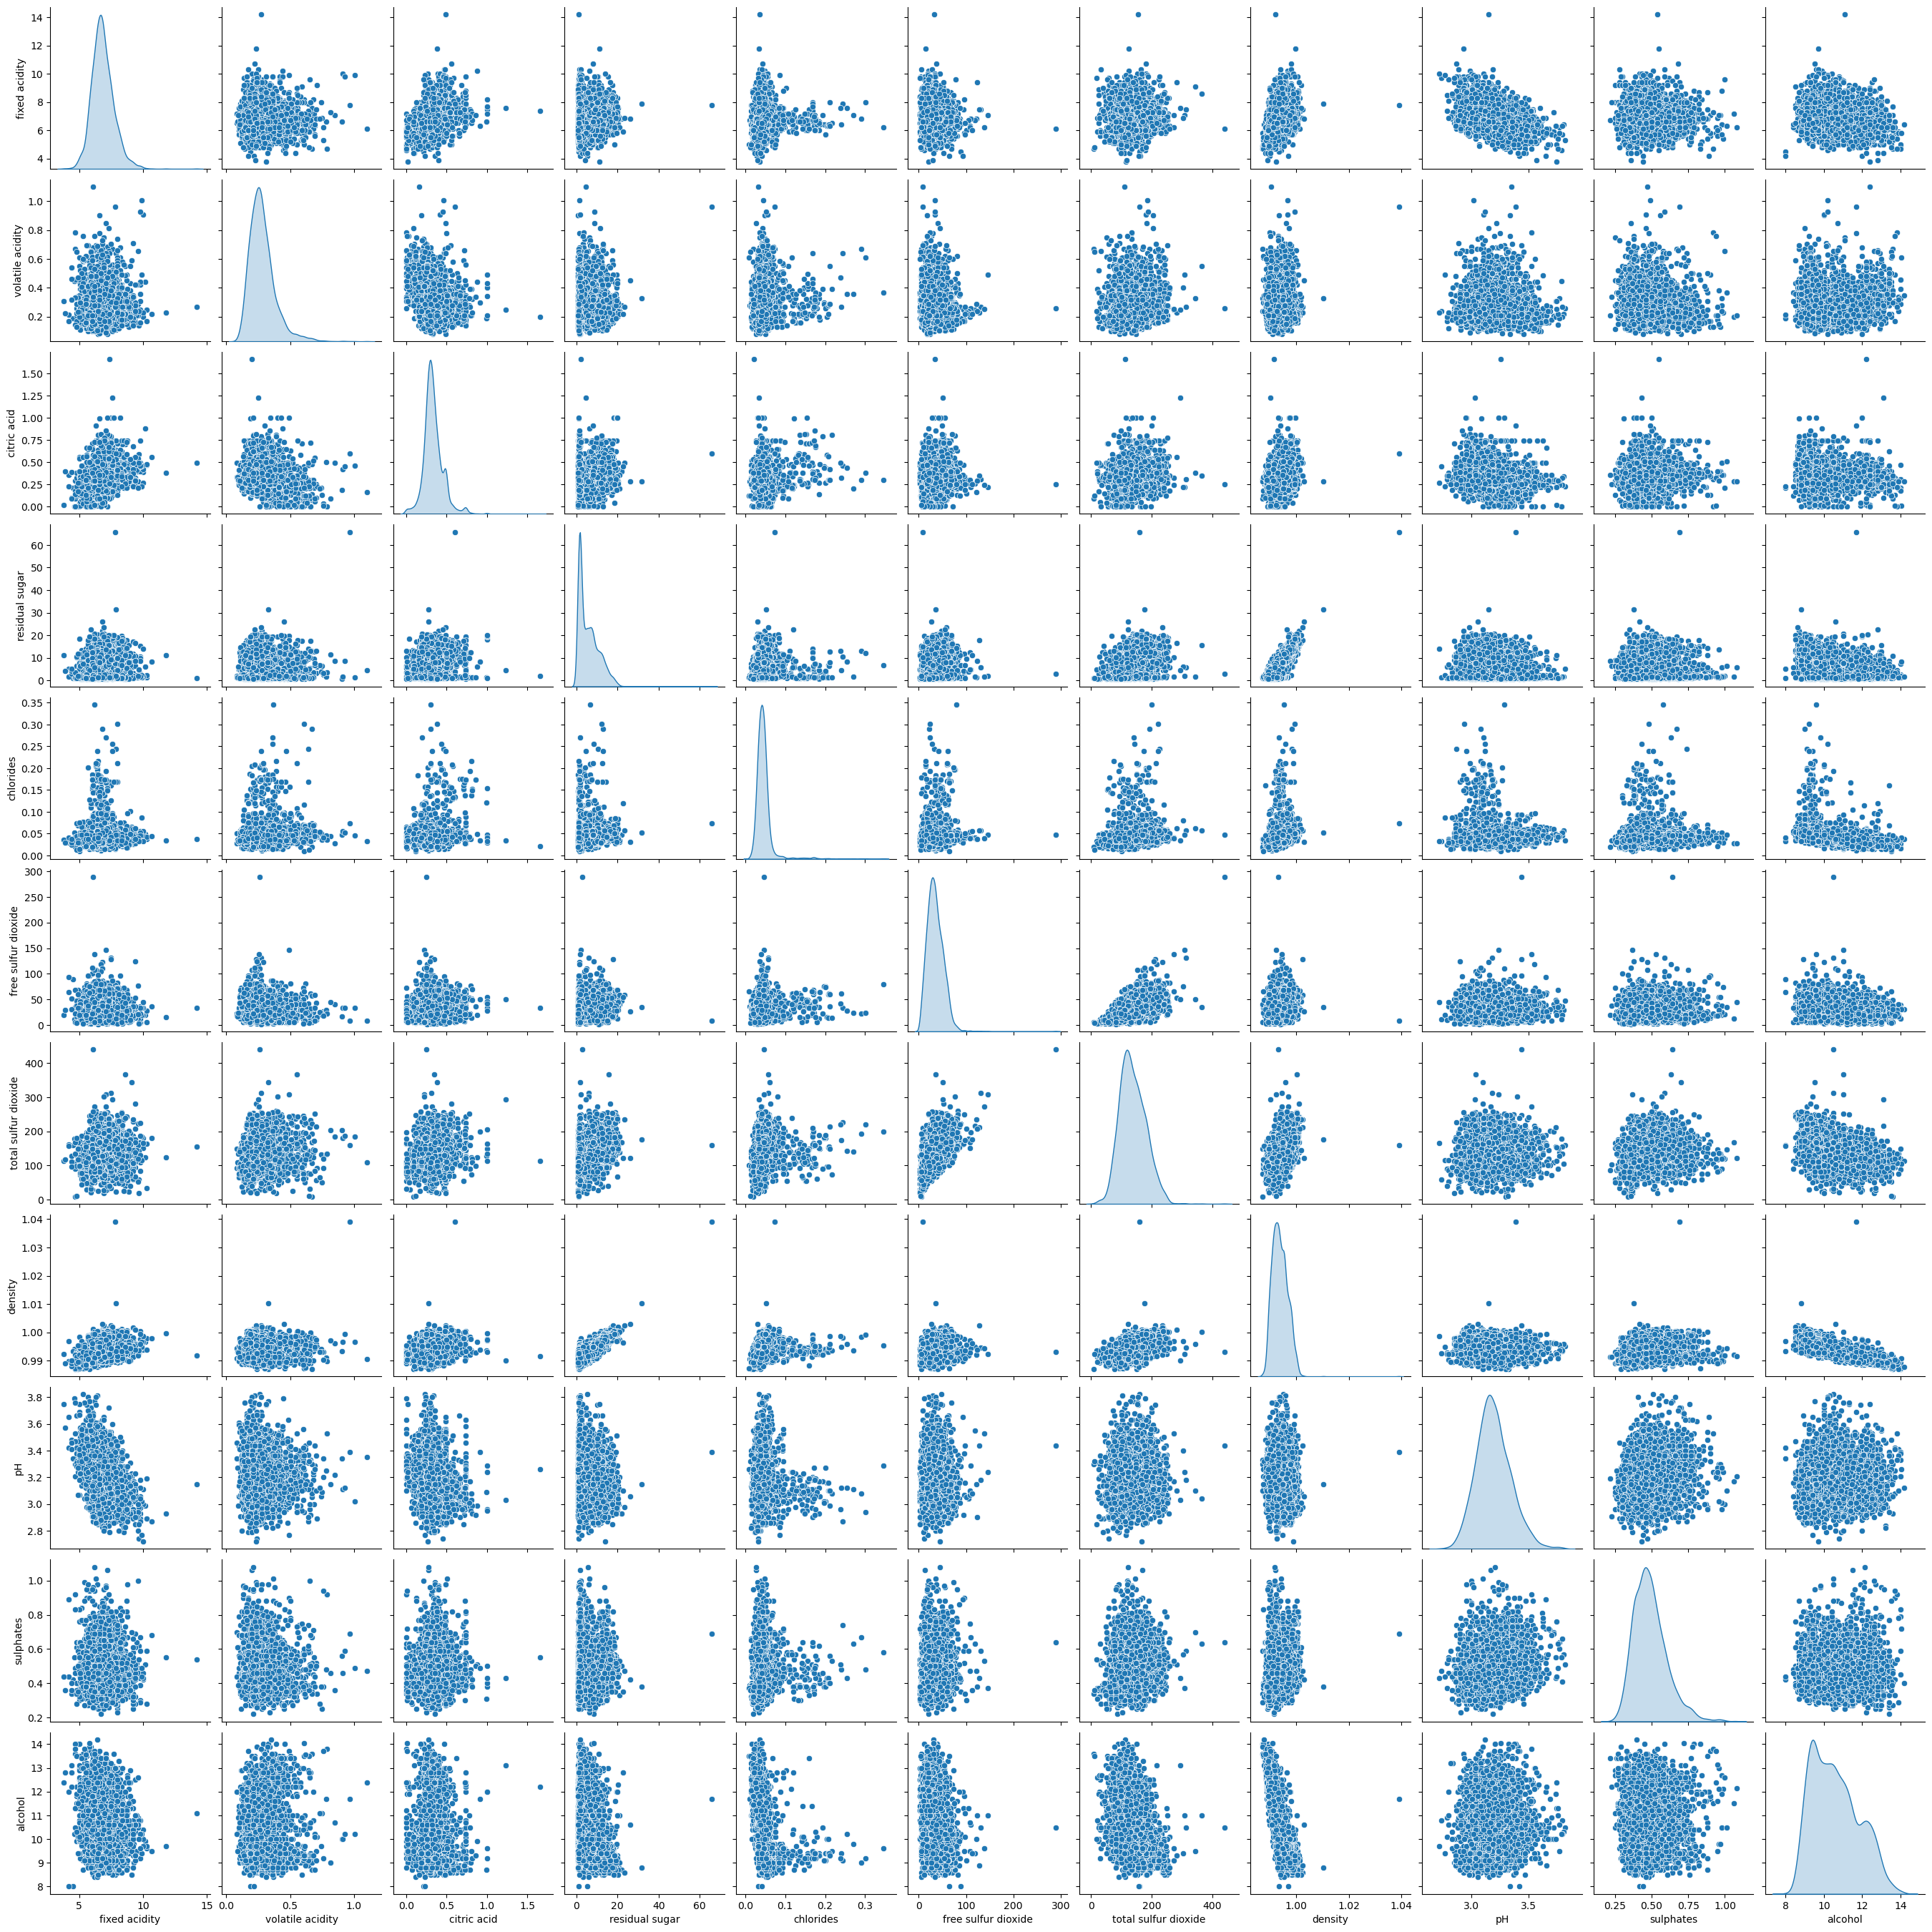

In [8]:
sns.pairplot(dataset_pd.drop(columns=['quality'], inplace=False), kind='scatter', diag_kind='kde')

In [9]:
def plot_corr_matrix_diag(corr):
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    plot = (corr
     .style
     .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
     .highlight_null(color='#f1f1f1')  # Color NaNs grey
     .format(precision=2))
    
    return plot

In [10]:
corr = dataset_pd.drop(columns=['quality'], inplace=False).corr()
plot_corr_matrix_diag(corr)

In [11]:
plot_corr_matrix_diag(corr.mask(abs(corr)<=0.6))

Согласно матрице корреляций можно составить список пар признаков с корреляцией больше, чем $0.6$:
- [`residual sugar`, `density`]
- [`density`, `alcohol`]
- [`free sulfur dioxide`, `total sulfur dioxide`]

Что с этим делать? Согласно, например, __[этим данным](https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too/)__, пару [`free sulfur dioxide`, `total sulfur dioxide`] не стоит удалять из анализа. В надежде на лучшие результаты, не будем удалять фичи с высокими корреляциями, а применим PCA трансформацию.

In [12]:
#dataset_pd.drop(columns=['residual sugar'], inplace=True)
#dataset_pd


Оставим так. По условию задания нам не требуется удалять корреляции и выбросы данных, но __[согласно датасету](https://archive.ics.uci.edu/dataset/186/wine+quality)__ рекомендуется проводить более подробный анализ.

Обработка выбросов:

c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

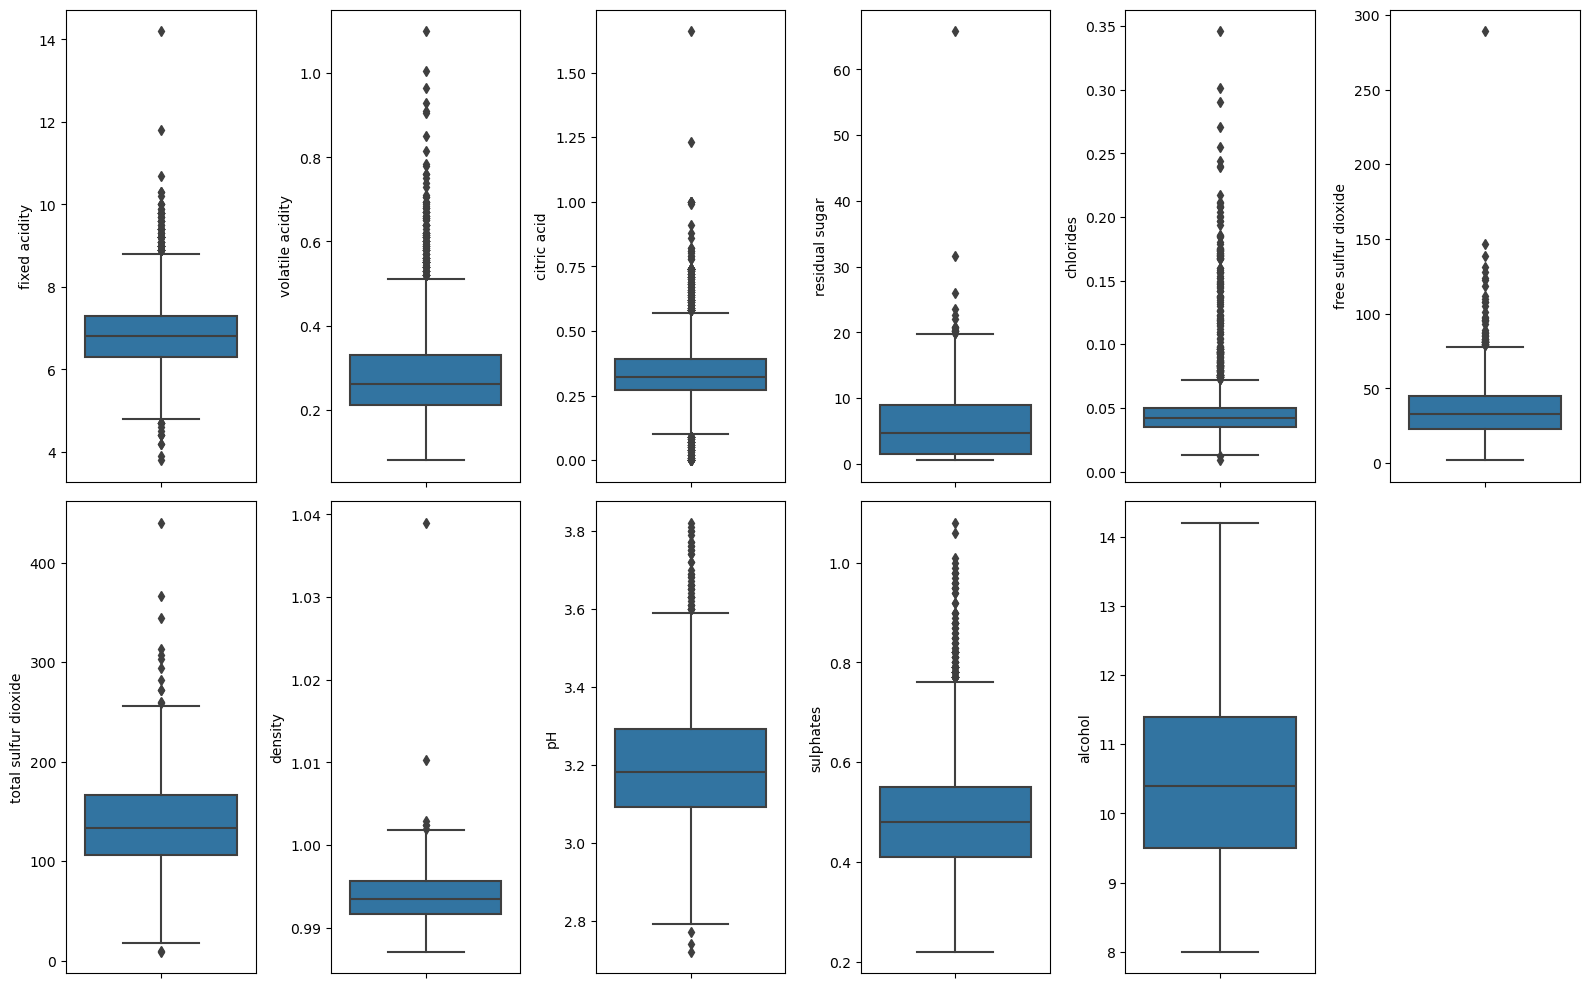

In [13]:
plt.figure(figsize=(16,10))

for i,col in enumerate(dataset_pd.drop(columns=['quality'], inplace=False).columns.tolist()):    
    plt.subplot(2,6,i + 1)
    sns.boxplot(y=col, data=dataset_pd.drop(columns=['quality'], inplace=False))

plt.tight_layout()

plt.show()

Согласно этим "ящикам с усами" и `sns.pairplot` можно сделать некоторые выводы по аномальным данных, т.е. по исключительным винам. Выбросы представлены черным ромбом на графиках выше - это статистически верные выбросы, но они могут нести определенную ценность в нахождении закономерностей среди образцов. Мы не будем удалять все выбросы, а удалим самые экстремальные:

In [14]:
test = dataset_pd.copy()
test.shape

(3961, 12)

In [15]:
test.drop(test[test["total sulfur dioxide"] >= 330].index, inplace=True)

In [16]:
test.drop(test[test["volatile acidity"] >= 0.85].index, inplace=True)

In [17]:
test.drop(test[test["citric acid"] >= 1.0].index, inplace=True)

In [18]:
test.drop(test[test["chlorides"] >= 0.3].index, inplace=True)

In [19]:
test.drop(test[test["free sulfur dioxide"] >= 200].index, inplace=True)

In [20]:
test.drop(test[test["fixed acidity"] >= 12].index, inplace=True)

In [21]:
test.drop(test[test["density"] >= 1.01].index, inplace=True)

In [22]:
test.drop(test[test["residual sugar"] >= 60].index, inplace=True)

Обновим исходный датасет:

In [23]:
dataset_pd = test.copy()
dataset_pd

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
6               6.2              0.32         0.16             7.0      0.045   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
6                    30.0                 136.0  0.99490  3.18       0.47   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  
0         8.8        6  
1         9.5        6  
2        10.1        6  
3         9.9        6  
6         9.6        6  
...       ...      ...  
4893     11.2        6  
4894      9.6        5  
4895      9.4        6  
4896     12.8        7  
4897     11.8        6  

[3940 rows x 12 columns]

c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

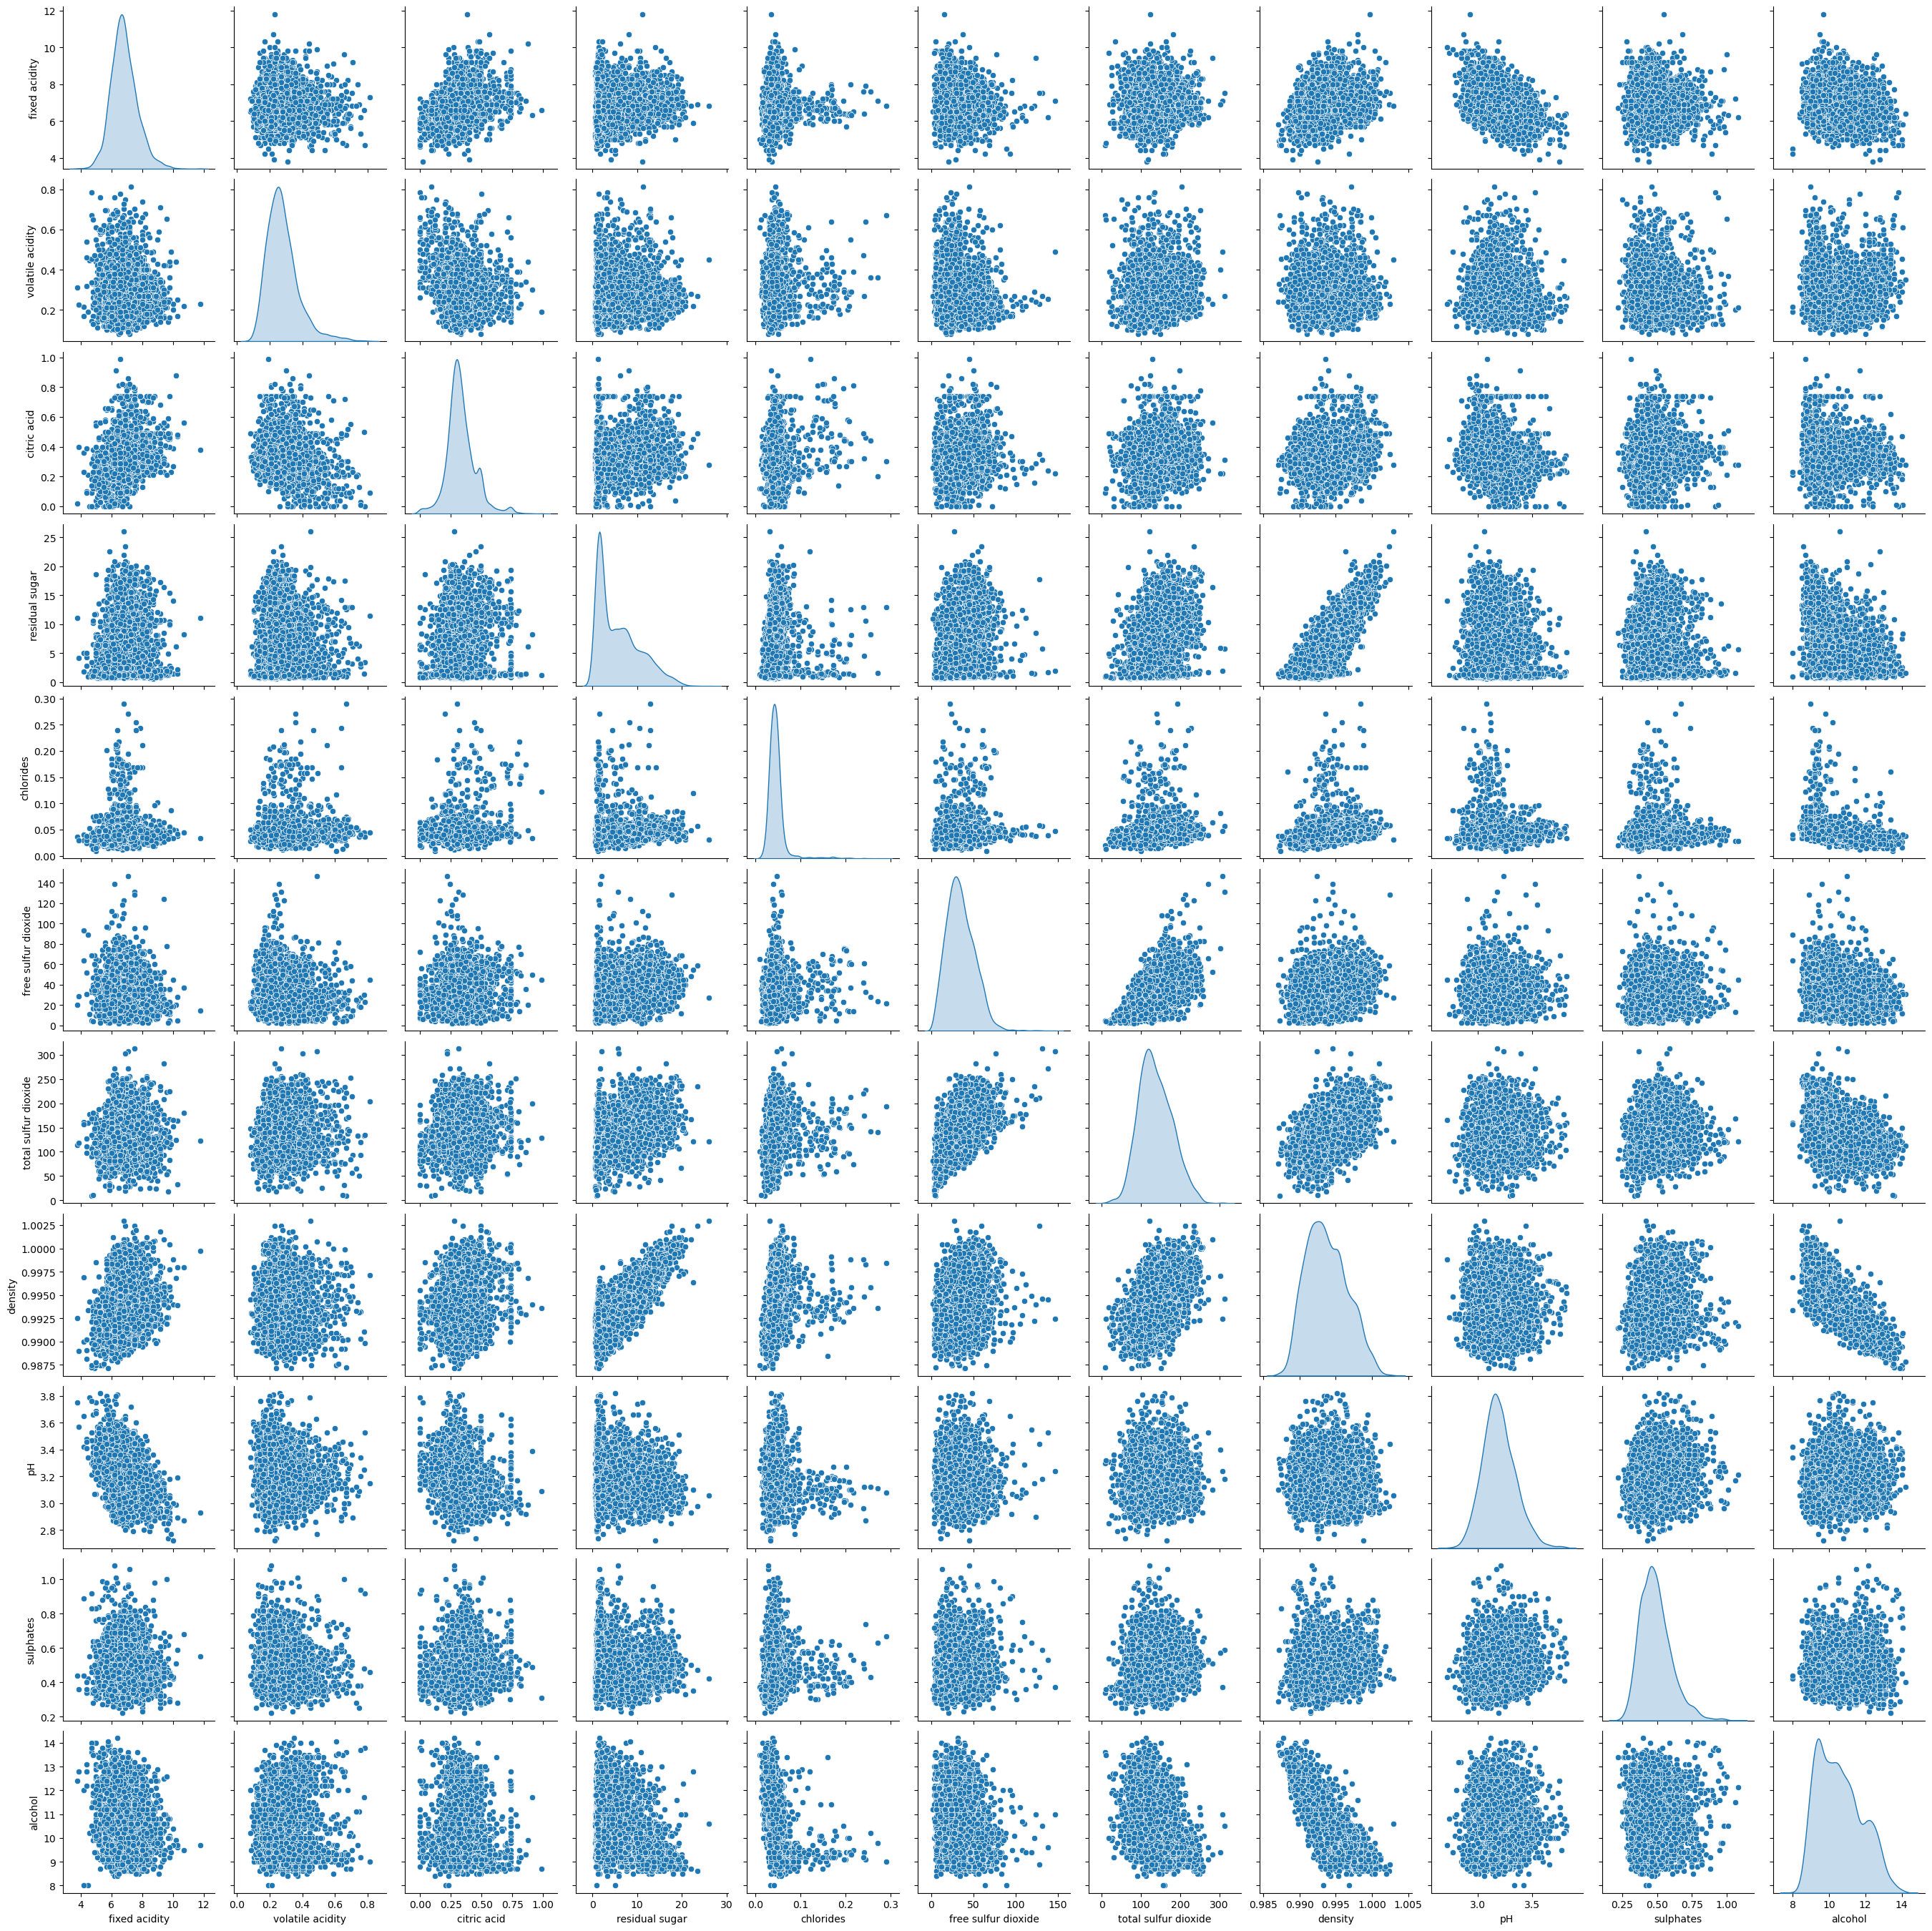

In [24]:
sns.pairplot(dataset_pd.drop(columns=['quality'], inplace=False), kind='scatter', diag_kind='kde')

___

Начнем трансформацию данных:

In [25]:
dataset_np = dataset_pd.to_numpy()
data = dataset_np[:, :-1].astype(float)
target = dataset_np[:, -1]

print(data.shape, target.shape)

(3940, 11) (3940,)


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.30, random_state=777)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2758, 11) (2758,) (1182, 11) (1182,)


Т.к. у нас остались аномальные данные, стоит использовать `RobustScaler` вместо `StandartScaler` - таким образом мы учтем эти выбросы в стандартизации данных.

In [27]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(X_train)
#scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучение модели регрессии

Постройте модель регрессии, используя 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

Для начала используйте гиперпараметры по умолчанию.

Рассчитайте среднее качество кросс-валидации модели как долю дисперсии зависимой переменной (коэффициент детерминации) $R^2$. Каким получилось качество? Какой алгоритм вы бы выбрали для дальнейшей работы? Обоснуйте свой выбор.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

dt_basic = DecisionTreeRegressor(random_state=RANDOM_STATE)
ab_basic = AdaBoostRegressor(random_state=RANDOM_STATE)
rf_basic = RandomForestRegressor(random_state=RANDOM_STATE) # ради интереса: будем также использовать 'max_features': None, который эмпирически больше подходит под задачу регрессии. Результаты в сравнении без/с PCA трансформацией.

In [29]:
custom_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
print("r2 scoring")

for estimator in {dt_basic, ab_basic, rf_basic}:
    res = cross_val_score(estimator, X_train_scaled, y_train, scoring='r2', cv=custom_cv)
    mean = sum(res)/len(res)
    print(str(estimator.__class__.__name__), ": ", mean, sep='')

r2 scoring


AdaBoostRegressor: 0.26543673444096766
RandomForestRegressor: 0.3654524214650883
DecisionTreeRegressor: -0.2512801446600439


In [30]:
# Сделаем анализ исходного дерева с отрицательным r2-score
dt_basic.fit(X_train_scaled, y_train)
path = dt_basic.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [31]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = clone(dt_basic)
    clf.set_params(ccp_alpha=ccp_alpha, max_depth=None, random_state=RANDOM_STATE)
    clf.fit(X_train_scaled, y_train)
    clfs.append(clf)

In [32]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

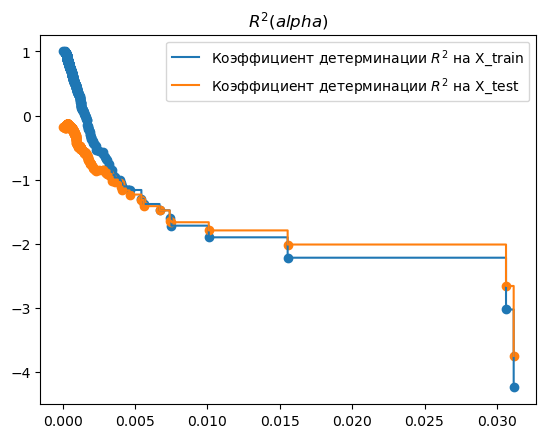

In [33]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train_scaled)
    y_test_pred = c.predict(X_test_scaled)
    train_acc.append(r2_score(c.predict(X_train_scaled),y_train))
    test_acc.append(r2_score(c.predict(X_test_scaled),y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='Коэффициент детерминации $R^2$ на X_train',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='Коэффициент детерминации $R^2$ на X_test',drawstyle="steps-post")
plt.legend()
plt.title('$R^2(alpha)$')
plt.show()

Согласно графику, стоит выбрать `ccp_alpha` $\in [0.007; 0.015]$, чтобы не потерять в возможности точно предсказывать ответы. Пусть `ccp_alpha` $=0.008$

In [34]:
ccp_alpha_hand_picked = 0.008
dt_basic_pruned=clone(dt_basic)
dt_basic_pruned.set_params(ccp_alpha=ccp_alpha_hand_picked, max_depth=None, random_state=42)

dt_basic_pruned.fit(X_train_scaled, y_train)
print("r2_score:", r2_score(y_test, dt_basic_pruned.predict(X_test_scaled)))

r2_score: 0.2755335480605262


Итого у дерева с прунингом на всей тренировочной выборке скор значительно повысился! Теперь построим модель с найденным значением `ccp_alpha` и проведем ее кросс-валидацию:

In [35]:
res_noGridSearch_noPCA = {}
for estimator in {dt_basic, dt_basic_pruned, ab_basic, rf_basic}:
    res = cross_val_score(estimator, X_train_scaled, y_train, scoring='r2', cv=custom_cv)
    mean = round(sum(res)/len(res), 4)

    # форматирование вывода
    if (estimator.__class__.__name__ == "DecisionTreeRegressor"):
        #print(estimator.get_params())
        dt_dict = estimator.get_params()
        if (dt_dict['ccp_alpha'] != 0.0):
            print("Pruned "+str(estimator.__class__.__name__)+" with ccp_alpha="+str(dt_dict['ccp_alpha']), ": ", mean, sep='')
            res_noGridSearch_noPCA['pruned'] = mean
        else:
            print("Non-pruned "+str(estimator.__class__.__name__), ": ", mean, sep='')
            res_noGridSearch_noPCA['non_pruned'] = mean
    else:
        print(str(estimator.__class__.__name__), ": ", mean, sep='')
        res_noGridSearch_noPCA[str(estimator.__class__.__name__)] = mean

AdaBoostRegressor: 0.2654
Pruned DecisionTreeRegressor with ccp_alpha=0.008: 0.2484
RandomForestRegressor: 0.3655
Non-pruned DecisionTreeRegressor: -0.2513


По итогу получается печальная картина, когда у одних из самых сильных моделей Коэффициент детерминации $R^2$ составляет $0.3-0.4$ . После прунинга дерева скор относительно обычного дерева сильно улучшился - $0.25$. Далее будем работать с `AdaBoostRegressor`.

___

Теперь сделаем подбор оптимальных гиперпараметров. Сделайте поиск по сетке с помощью кросс-валидации. Изменилось ли качество алгоритмов? Почему?

In [36]:
dt_better = DecisionTreeRegressor(random_state=RANDOM_STATE)
ab_better = AdaBoostRegressor(random_state=RANDOM_STATE)
rf_better = RandomForestRegressor(random_state=RANDOM_STATE)

In [37]:
res_withGridSearch_noPCA = {}
def print_params(res):
    for key in res:
        value = res[key]
        if key == "ccp_alpha":
            print('\t', str(key)+" =", value)
        if key == "criterion":
            print('\t', str(key)+" =", value)
        if key == "max_depth":
            print('\t', str(key)+" =", value)
        if key == "max_features":
            print('\t', str(key)+" =", value)
        if key == "learning_rate":
            print('\t', str(key)+" =", value)
        if key == "loss":
            print('\t', str(key)+" =", value)
        if key == "n_estimators":
            print('\t', str(key)+" =", value)

## **Решающее дерево**

Попробуем внедрить в поиск по сетке прунинг дерева - поиск оптимального `ccp_alpha`:

In [38]:
param_grid = {'max_features': ['sqrt', 'log2'],
              'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion' :['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
              'ccp_alpha' : [0.000, 0.002, 0.004, 0.006, 0.008, 0.010],
             }

grid_search_dt = GridSearchCV(estimator=dt_better, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_dt.fit(X_train_scaled, y_train)

dt_better = grid_search_dt.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(dt_better.get_params())

res_withGridSearch_noPCA['pruned'] = grid_search_dt.best_score_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


best estimator hyperparameters:
	 ccp_alpha = 0.002
	 criterion = squared_error
	 max_depth = 6
	 max_features = sqrt


In [39]:
print("Decision Tree with general hyperparameters: r2 score =", res_noGridSearch_noPCA['pruned'])
print("Decision Tree with oprimal hyperparameters: r2 score =", res_withGridSearch_noPCA['pruned'])

Decision Tree with general hyperparameters: r2 score = 0.2484
Decision Tree with oprimal hyperparameters: r2 score = 0.21623922498582118


Здесь и далее мы увидим незначительные увеличения точности модели при подборе оптимальных гиперпараметров. Это можно обосновать тем, что большинство гиперпараметров выставляются автоматически, согласно документации SKLearn.

## **AdaBoost**

In [40]:
param_grid = {'loss': ['linear', 'square', 'exponential'],
              'n_estimators': [10, 50, 100, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
             }

grid_search_ab = GridSearchCV(estimator=ab_better, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_ab.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=43, shuffle=True),
             estimator=AdaBoostRegressor(random_state=43),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='r2', verbose=1)

In [41]:
ab_better = grid_search_ab.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(ab_better.get_params())

res_withGridSearch_noPCA[str(ab_better.__class__.__name__)] = grid_search_ab.best_score_

best estimator hyperparameters:
	 learning_rate = 0.1
	 loss = linear
	 n_estimators = 100


In [42]:
name = str(ab_better.__class__.__name__)
print("AdaBoost Regressor with general hyperparameters: r2 score =", res_noGridSearch_noPCA[name])
print("AdaBoost Regressor with oprimal hyperparameters: r2 score =", res_withGridSearch_noPCA[name])

AdaBoost Regressor with general hyperparameters: r2 score = 0.2654
AdaBoost Regressor with oprimal hyperparameters: r2 score = 0.29348840044135577


## **Случайный лес**

In [43]:
param_grid = {'max_features': ['sqrt', 'log2', None],
              'n_estimators': [10, 50, 100, 500],
              'criterion' :['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
             }

grid_search_rf = GridSearchCV(estimator=rf_better, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_rf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=43, shuffle=True),
             estimator=RandomForestRegressor(random_state=43),
             param_grid={'criterion': ['poisson', 'squared_error',
                                       'absolute_error', 'friedman_mse'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='r2', verbose=1)

In [44]:
rf_better = grid_search_rf.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(rf_better.get_params())

res_withGridSearch_noPCA[str(rf_better.__class__.__name__)] = grid_search_rf.best_score_

best estimator hyperparameters:
	 ccp_alpha = 0.0
	 criterion = poisson
	 max_depth = None
	 max_features = sqrt
	 n_estimators = 500


In [45]:
name = str(rf_better.__class__.__name__)
print("Random Forest Regressor with general hyperparameters: r2 score =", res_noGridSearch_noPCA[name])
print("Random Forest Regressor with oprimal hyperparameters: r2 score =", res_withGridSearch_noPCA[name])

Random Forest Regressor with general hyperparameters: r2 score = 0.3655
Random Forest Regressor with oprimal hyperparameters: r2 score = 0.38260497194135085


Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

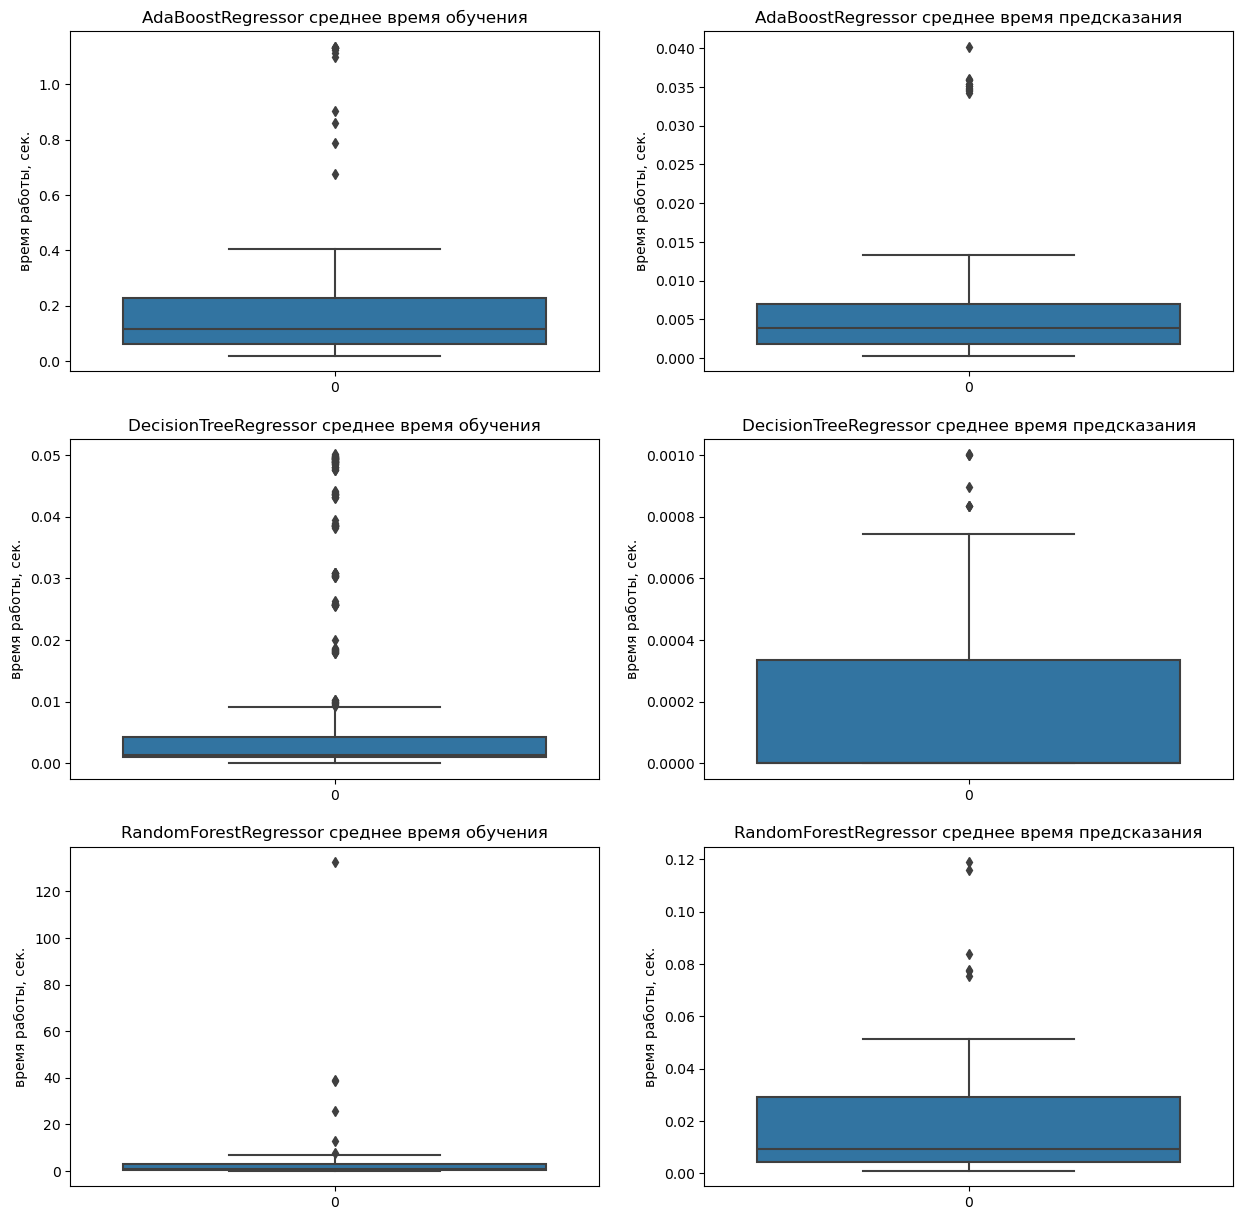

In [46]:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
i = 0

for GSCV in {grid_search_dt, grid_search_ab, grid_search_rf}:
    mft = GSCV.cv_results_["mean_fit_time"]
    mst = GSCV.cv_results_["mean_score_time"]

    sns.boxplot(data=mft, ax=ax[i, 0])
    ax[i, 0].set_title(str(GSCV.best_estimator_.__class__.__name__)+" среднее время обучения")
    ax[i, 0].set_ylabel("время работы, сек.")

    sns.boxplot(data=mst, ax=ax[i, 1])
    ax[i, 1].set_title(str(GSCV.best_estimator_.__class__.__name__)+" среднее время предсказания")
    ax[i, 1].set_ylabel("время работы, сек.")

    i+=1

Наблюдаем следующую картину: на графиках четко выделены аномальные значения. `seaborn.boxplot` выделяет их черными ромбами - значения, для которых выполняется: 
$$value \in (-\infty; Q_1-1.5\times IQR)\ \cup \ (Q_3+1.5\times IQR; + \infty) $$

Рассмотрим подробно какие гиперпараметры повлияли на появление таких данных:

In [47]:
for GSCV in {grid_search_dt, grid_search_ab, grid_search_rf}:
    mft = GSCV.cv_results_["mean_fit_time"]
    # mst = GSCV.cv_results_["mean_score_time"]

    q1 = np.quantile(mft, 0.25)
    q3 = np.quantile(mft, 0.75)
    iqr = q3-q1
    lower_b = q1-(1.5*iqr)
    upper_b = q3+(1.5*iqr)
    values = list(mft)

    # Считаем выбросы
    outlier_arr = []
    print("Параметры моделей "+str(GSCV.best_estimator_.__class__.__name__)+", для которых время предсказания позиционируется как аномальное значение:")

    for elem in values:
        if elem > upper_b:
            outlier_arr.append(values.index(elem))

    for idx in outlier_arr:
        print(GSCV.cv_results_['params'][idx])

    print("\n")
    

Параметры моделей AdaBoostRegressor, для которых время предсказания позиционируется как аномальное значение:
{'learning_rate': 0.0001, 'loss': 'linear', 'n_estimators': 500}
{'learning_rate': 0.0001, 'loss': 'square', 'n_estimators': 500}
{'learning_rate': 0.0001, 'loss': 'exponential', 'n_estimators': 500}
{'learning_rate': 0.001, 'loss': 'linear', 'n_estimators': 500}
{'learning_rate': 0.001, 'loss': 'square', 'n_estimators': 500}
{'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 500}
{'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
{'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
{'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
{'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 500}
{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 500}
{'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}


Параметры моделей DecisionTreeRegressor,

In [70]:
# В случайном лесе есть один набор гиперпараметров, который занимает больше 2 минут (!!!) на обучение. Посмотрим на его параметры:
mft = list(grid_search_rf.cv_results_["mean_fit_time"])

for elem in mft:
        if elem > 90:
            print(f'Время обучения составило {elem:.3f} секунд\n')
            anomaly_idx = mft.index(elem)
print("Гиперпараметры модели:")
print(grid_search_rf.cv_results_['params'][anomaly_idx])

Время обучения составило 132.649 секунд

Гиперпараметры модели:
{'criterion': 'absolute_error', 'max_features': None, 'n_estimators': 500}


Выводы аналогичны работе с датасетом красного вина: MAE реализован за $O(n^2)$, к тому же большое количество регрессеров в ансамблях тоже играет свою роль.

**Как ускорить?**: использовать эффективную и подходящую реализацию вспомогательных функций. Также с увеличением количества регрессеров в ансамбле, в какой-то момент качество модели выходит на плато - поэтому не стоит использовать много естиматоров.

## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

Достаточно использовать `svd_solver='full'`, т.к. размерность матрицы не столь огромна, чтобы использовать `svd_solver='randomized'`, а `svd_solver='arpack'` не совсем подходит для нашей задачи оценки количества компонент: согласно __[документации SKLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)__:

$$ n_{components} \in (0, min(dim(X)))$$

А нам надо объяснить отклонение при всех признаках

In [49]:
pca_full = PCA(n_components=X_train.shape[1], svd_solver='full', random_state=RANDOM_STATE)
pca_full.fit(X_train_scaled)

PCA(n_components=11, random_state=43, svd_solver='full')

Text(0, 0.5, 'Explained Variance (объясненное отклонение), ratio')

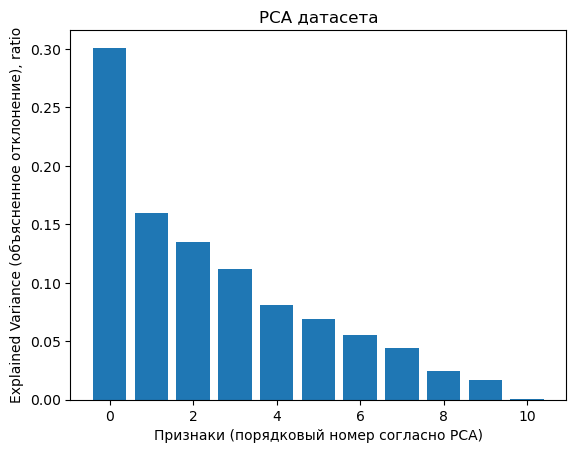

In [50]:
fig, ax = plt.subplots(1, 1)
res = pca_full.explained_variance_ratio_
ax.bar(list(range(0,len(res))), res)
ax.set_title("PCA датасета")
ax.set_xlabel("Признаки (порядковый номер согласно PCA)")
ax.set_ylabel("Explained Variance (объясненное отклонение), ratio")

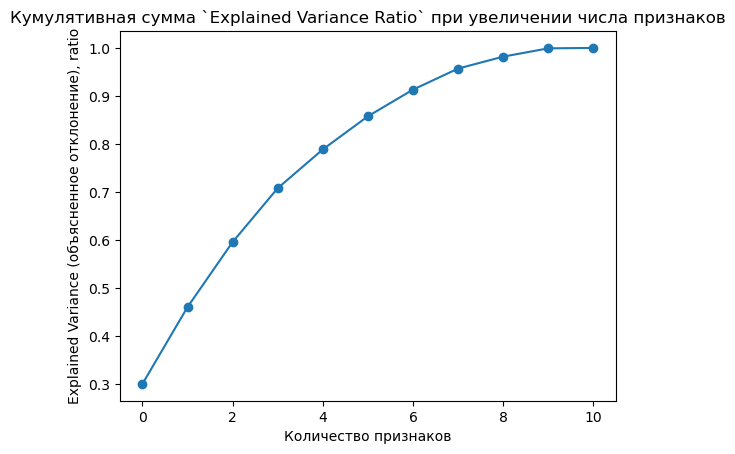

In [51]:
cumulative_variance_ratio = np.cumsum(res)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Количество признаков')
plt.ylabel('Explained Variance (объясненное отклонение), ratio')
plt.title('Кумулятивная сумма `Explained Variance Ratio` при увеличении числа признаков')
plt.show()

Видно, что наибольший вклад в предсказание моделей можно добиться 10 признаками.

In [52]:
pca = PCA(n_components=10, svd_solver='full', random_state=RANDOM_STATE) # Подобрал
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Обучение моделей на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Какой алгоритм справился лучше? Какой быстрее? Почему?

In [53]:
dt_better_pca = DecisionTreeRegressor(random_state=RANDOM_STATE)
ab_better_pca = AdaBoostRegressor(random_state=RANDOM_STATE)
rf_better_pca = RandomForestRegressor(random_state=RANDOM_STATE)
res_withGridSearch_withPCA = {}

## **Решающее дерево**

Снова внедряем в поиск по сетке прунинг дерева - поиск оптимального `ccp_alpha`:

In [54]:
param_grid = {'max_features': ['sqrt', 'log2'],
              'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion' :['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
              'ccp_alpha' : [0.000, 0.002, 0.004, 0.006, 0.008, 0.010],
             }

grid_search_dt_pca = GridSearchCV(estimator=dt_better_pca, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_dt_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=43, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=43),
             param_grid={'ccp_alpha': [0.0, 0.002, 0.004, 0.006, 0.008, 0.01],
                         'criterion': ['poisson', 'squared_error',
                                       'absolute_error', 'friedman_mse'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2']},
             scoring='r2', verbose=1)

In [55]:
dt_better_pca = grid_search_dt_pca.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(dt_better_pca.get_params())

res_withGridSearch_withPCA['pruned'] = grid_search_dt_pca.best_score_

best estimator hyperparameters:
	 ccp_alpha = 0.004
	 criterion = squared_error
	 max_depth = 5
	 max_features = sqrt


In [56]:
print("Decision Tree with general hyperparameters w//o PCA: r2 score =", res_noGridSearch_noPCA['pruned'])
print("Decision Tree with oprimal hyperparameters w//o PCA: r2 score =", res_withGridSearch_noPCA['pruned'])
print("Decision Tree with oprimal hyperparameters with PCA: r2 score =", res_withGridSearch_withPCA['pruned'])

Decision Tree with general hyperparameters w//o PCA: r2 score = 0.2484
Decision Tree with oprimal hyperparameters w//o PCA: r2 score = 0.21623922498582118
Decision Tree with oprimal hyperparameters with PCA: r2 score = 0.21139315307212914


## **AdaBoost**

In [57]:
param_grid = {'loss': ['linear', 'square', 'exponential'],
              'n_estimators': [10, 50, 100, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
             }

grid_search_ab_pca = GridSearchCV(estimator=ab_better_pca, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_ab_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=43, shuffle=True),
             estimator=AdaBoostRegressor(random_state=43),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='r2', verbose=1)

In [58]:
ab_better_pca = grid_search_ab_pca.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(ab_better_pca.get_params())

res_withGridSearch_withPCA[str(ab_better_pca.__class__.__name__)] = grid_search_ab_pca.best_score_

best estimator hyperparameters:
	 learning_rate = 0.1
	 loss = exponential
	 n_estimators = 100


In [59]:
name = str(ab_better_pca.__class__.__name__)
print("AdaBoost Regressor with general hyperparameters w//o PCA: r2 score =", res_noGridSearch_noPCA[name])
print("AdaBoost Regressor with oprimal hyperparameters w//o PCA: r2 score =", res_withGridSearch_noPCA[name])
print("AdaBoost Regressor with oprimal hyperparameters with PCA: r2 score =", res_withGridSearch_withPCA[name])

AdaBoost Regressor with general hyperparameters w//o PCA: r2 score = 0.2654
AdaBoost Regressor with oprimal hyperparameters w//o PCA: r2 score = 0.29348840044135577
AdaBoost Regressor with oprimal hyperparameters with PCA: r2 score = 0.2746836741059951


## **Случайный лес**

In [60]:
param_grid = {'max_features': ['sqrt', 'log2', None],
              'n_estimators': [10, 50, 100, 500],
              'criterion' :['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
             }

grid_search_rf_pca = GridSearchCV(estimator=rf_better_pca, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_rf_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=43, shuffle=True),
             estimator=RandomForestRegressor(random_state=43),
             param_grid={'criterion': ['poisson', 'squared_error',
                                       'absolute_error', 'friedman_mse'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='r2', verbose=1)

In [61]:
rf_better_pca = grid_search_rf_pca.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(rf_better_pca.get_params())

res_withGridSearch_withPCA[str(rf_better_pca.__class__.__name__)] = grid_search_rf_pca.best_score_

best estimator hyperparameters:
	 ccp_alpha = 0.0
	 criterion = squared_error
	 max_depth = None
	 max_features = sqrt
	 n_estimators = 500


In [62]:
name = str(rf_better_pca.__class__.__name__)
print("Random Forest Regressor with general hyperparameters w//o PCA: r2 score =", res_noGridSearch_noPCA[name])
print("Random Forest Regressor with oprimal hyperparameters w//o PCA: r2 score =", res_withGridSearch_noPCA[name])
print("Random Forest Regressor with oprimal hyperparameters with PCA: r2 score =", res_withGridSearch_withPCA[name])

Random Forest Regressor with general hyperparameters w//o PCA: r2 score = 0.3655
Random Forest Regressor with oprimal hyperparameters w//o PCA: r2 score = 0.38260497194135085
Random Forest Regressor with oprimal hyperparameters with PCA: r2 score = 0.35005020910130624


## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о моделях регрессии с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

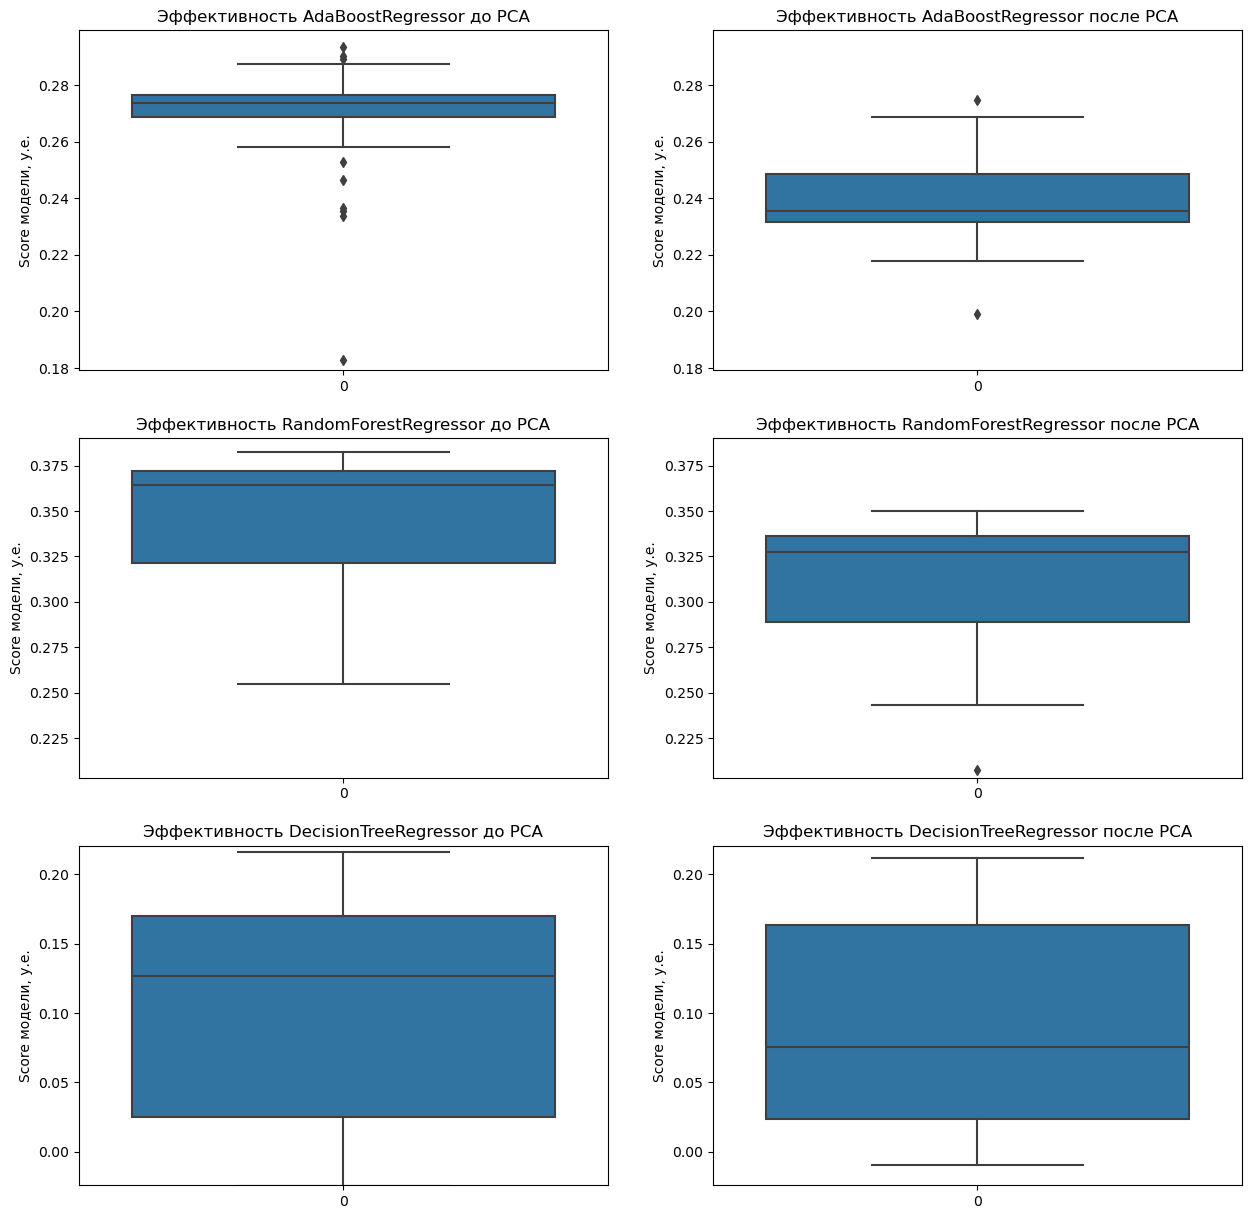

In [63]:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
i = 0

pairs = {(grid_search_dt, grid_search_dt_pca), (grid_search_ab, grid_search_ab_pca), (grid_search_rf, grid_search_rf_pca)}

for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_score"]
    mts_pca = GSCV[1].cv_results_["mean_test_score"]

    # Для читаемости
    min = np.min(mts_cmn) if (np.min(mts_pca) > np.min(mts_cmn)) else np.min(mts_pca)
    max = np.max(mts_cmn) if (np.max(mts_pca) < np.max(mts_cmn)) else np.max(mts_pca)
    mul = 1.02
    min /= mul
    max *= mul

    sns.boxplot(data=mts_cmn, ax=ax[i, 0])
    ax[i, 0].set_title("Эффективность "+str(GSCV[0].best_estimator_.__class__.__name__)+" до PCA")
    ax[i, 0].set_ylabel("Score модели, у.е.")
    ax[i, 0].set(ylim=(min, max))

    sns.boxplot(data=mts_pca, ax=ax[i, 1])
    ax[i, 1].set_title("Эффективность "+str(GSCV[1].best_estimator_.__class__.__name__)+" после PCA")
    ax[i, 1].set_ylabel("Score модели, у.е.")
    ax[i, 1].set(ylim=(min, max))

    i+=1

Посмотрим сначала на параметры моделей со следующим условием:
$$ score \in (Q3;\ Q3+1.5\times IQR) $$

In [64]:
for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_score"]
    mts_pca = GSCV[1].cv_results_["mean_test_score"]

    i = 0
    models = [[], []]
    print("Параметры моделей "+str(GSCV[-1].best_estimator_.__class__.__name__)+", для которых качество предсказания (mean test score) лучше верхнего квартиля (и не аномальное):")

    for scores in (mts_cmn, mts_pca):
        q1 = np.quantile(scores, 0.25)
        q3 = np.quantile(scores, 0.75)
        iqr = q3-q1
        lower_b = q1-(1.5*iqr)
        upper_b = q3+(1.5*iqr)
        values = list(scores)

        for elem in values:
            if elem < upper_b and elem > q3:
                models[i].append(values.index(elem))
        
        if i==0:
            print("\tПараметры моделей до PCA:")
        else:
            print("\tПараметры моделей после PCA:")

        for idx in models[i]:
            print(f"\t\t {GSCV[i].cv_results_['params'][idx]}, score={GSCV[i].cv_results_['mean_test_score'][idx]:.3f}")

        ###
        print('\n')
        i+=1

Параметры моделей AdaBoostRegressor, для которых качество предсказания (mean test score) лучше верхнего квартиля (и не аномальное):
	Параметры моделей до PCA:
		 {'learning_rate': 0.0001, 'loss': 'square', 'n_estimators': 500}, score=0.277
		 {'learning_rate': 0.001, 'loss': 'linear', 'n_estimators': 500}, score=0.277
		 {'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 500}, score=0.278
		 {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}, score=0.283
		 {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}, score=0.282
		 {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50}, score=0.277
		 {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 100}, score=0.279
		 {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}, score=0.286
		 {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 50}, score=0.287
		 {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 50}, score=0.280
		 {'learning_rate': 0.1, 'loss'

Выводы аналогично задаче с датасетом красного вина.

____

Теперь посмотрим на аномально высокие скоры, т.е. для которых выполняется:
$$ score > Q3+1.5\times IQR $$

Если таких данных не будет, то напишем параметры лучшей модели.

In [65]:
for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_score"]
    mts_pca = GSCV[1].cv_results_["mean_test_score"]

    i = 0
    models = [[], []]
    print("Параметры моделей "+str(GSCV[-1].best_estimator_.__class__.__name__)+", для которых качество предсказания (mean test score) аномально-высокое:")

    for scores in (mts_cmn, mts_pca):
        q1 = np.quantile(scores, 0.25)
        q3 = np.quantile(scores, 0.75)
        iqr = q3-q1
        lower_b = q1-(1.5*iqr)
        upper_b = q3+(1.5*iqr)
        values = list(scores)

        for elem in values:
            if elem >= upper_b:
                models[i].append(values.index(elem))

        if i==0:
            if models[i] == []:
                print(f"\tПараметры лучшей модели до PCA: \n\t\t{GSCV[i].best_estimator_.get_params(False)}")
            else:
                print("\tПараметры моделей до PCA:")
        else:
            if models[i] == []:
                print(f"\tПараметры лучшей модели после PCA: \n\t\t{GSCV[i].best_estimator_.get_params(False)}")
            else:
                print("\tПараметры моделей после PCA:")

        for idx in models[i]:
            print(f"\t\t {GSCV[i].cv_results_['params'][idx]}, score={GSCV[i].cv_results_['mean_test_score'][idx]:.3f}")

        ###
        print('\n')
        i+=1

Параметры моделей AdaBoostRegressor, для которых качество предсказания (mean test score) аномально-высокое:
	Параметры моделей до PCA:
		 {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 100}, score=0.293
		 {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 500}, score=0.290
		 {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}, score=0.289


	Параметры моделей после PCA:
		 {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}, score=0.275


Параметры моделей RandomForestRegressor, для которых качество предсказания (mean test score) аномально-высокое:
	Параметры лучшей модели до PCA: 
		{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 43, 'verbose': 0, 'warm_star

Аномальные значения только у `AdaBoostRegressor`, но даже они меньше нижнего квартиля точности модели до PCA. Лучший скор (как до PCA, так и после) оказался у модели, в которой есть баланс между `learning_rate` и `n_estimators`, как ожидалось.

___

Теперь посмотрим на аномально низкие скоры, т.е. для которых выполняется:
$$ score < Q1-1.5\times IQR $$

Если таких данных не будет, то напишем параметры худшей модели.

In [66]:
for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_score"]
    mts_pca = GSCV[1].cv_results_["mean_test_score"]

    i = 0
    models = [[], []]
    print("Параметры моделей "+str(GSCV[-1].best_estimator_.__class__.__name__)+", для которых качество предсказания (mean test score) аномально-низкое:")

    for scores in (mts_cmn, mts_pca):
        q0 = np.quantile(scores, 0.0)
        q1 = np.quantile(scores, 0.25)
        q3 = np.quantile(scores, 0.75)
        iqr = q3-q1
        lower_b = q1-(1.5*iqr)
        upper_b = q3+(1.5*iqr)
        values = list(scores)

        lowest_idx = -1
        for elem in values:
            if elem == q0:
                lowest_idx = values.index(elem)
            if elem <= lower_b:
                models[i].append(values.index(elem))

        if i==0:
            if models[i] == []:
                print(f"\tПараметры худшей модели до PCA: \n\t\t{GSCV[i].cv_results_['params'][lowest_idx]}, score={GSCV[i].cv_results_['mean_test_score'][lowest_idx]:.3f}")
            else:
                print("\tПараметры моделей до PCA:")
        else:
            if models[i] == []:
                print(f"\tПараметры худшей модели после PCA: \n\t\t{GSCV[i].cv_results_['params'][lowest_idx]}, score={GSCV[i].cv_results_['mean_test_score'][lowest_idx]:.3f}")
            else:
                print("\tПараметры моделей после PCA:")

        for idx in models[i]:
            print(f"\t\t {GSCV[i].cv_results_['params'][idx]}, score={GSCV[i].cv_results_['mean_test_score'][idx]:.3f}")

        ###
        print('\n')
        i+=1

Параметры моделей AdaBoostRegressor, для которых качество предсказания (mean test score) аномально-низкое:
	Параметры моделей до PCA:
		 {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 500}, score=0.234
		 {'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 500}, score=0.253
		 {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 100}, score=0.247
		 {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 500}, score=0.236
		 {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 100}, score=0.236
		 {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}, score=0.183


	Параметры моделей после PCA:
		 {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}, score=0.199


Параметры моделей RandomForestRegressor, для которых качество предсказания (mean test score) аномально-низкое:
	Параметры худшей модели до PCA: 
		{'criterion': 'absolute_error', 'max_features': None, 'n_estimators': 10}, score=0.255


	Параметры моделей после PCA:
		 {'

**AdaBoost:** сюда попали модели без баланса между `learning_rate` и `n_estimators`: слишком малое значение обоих параметров приводит к слабой модели (без раскрытия потенциала идеи бустинга), тоже самое можно сказать про модель с максимальными значениями обоих параметров;

**Random Forest (только после PCA):** малое количество `n_estimators` в случайном лесу приводит к тем же результатам, что и в `AdaBoostRegressor`. К тому же тут играет роль MAE критерий, который, как мы поняли ранее, не эффективный.

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 30%). Не забудьте про все необходимые преобразования.

In [67]:
# (гиперпараметры по умолчанию, оптимальные гиперпараметры, оптимальные гиперпараметры после PCA)
pairs = {(dt_basic_pruned, grid_search_dt.best_estimator_, grid_search_dt_pca.best_estimator_), 
         (ab_basic.fit(X_train_scaled, y_train), grid_search_ab.best_estimator_, grid_search_ab_pca.best_estimator_), 
         (rf_basic.fit(X_train_scaled, y_train), grid_search_rf.best_estimator_, grid_search_rf_pca.best_estimator_)}

for estimators in pairs:
    print(f"Итоги для {estimators[0].__class__.__name__}")
    y_pred_basic = estimators[0].predict(X_test_scaled)
    r2_basic = r2_score(y_test, y_pred_basic)
    print(f"\tКоэффициент детерминации до PCA с гиперпараметрами по умолчанию: {r2_basic:.3f}")

    y_pred_better = estimators[1].predict(X_test_scaled)
    r2_better = r2_score(y_test, y_pred_better)
    print(f"\tКоэффициент детерминации до PCA с оптимальными гиперпараметрами: {r2_better:.3f}")

    y_pred_better_pca = estimators[2].predict(X_test_pca)
    r2_pca = r2_score(y_test, y_pred_better_pca)
    print(f"\tКоэффициент детерминации после PCA с оптимальными гиперпараметрами: {r2_pca:.3f}")

    print('\n')
    

Итоги для RandomForestRegressor
	Коэффициент детерминации до PCA с гиперпараметрами по умолчанию: 0.355
	Коэффициент детерминации до PCA с оптимальными гиперпараметрами: 0.388
	Коэффициент детерминации после PCA с оптимальными гиперпараметрами: 0.344


Итоги для DecisionTreeRegressor
	Коэффициент детерминации до PCA с гиперпараметрами по умолчанию: 0.276
	Коэффициент детерминации до PCA с оптимальными гиперпараметрами: 0.221
	Коэффициент детерминации после PCA с оптимальными гиперпараметрами: 0.218


Итоги для AdaBoostRegressor
	Коэффициент детерминации до PCA с гиперпараметрами по умолчанию: 0.271
	Коэффициент детерминации до PCA с оптимальными гиперпараметрами: 0.321
	Коэффициент детерминации после PCA с оптимальными гиперпараметрами: 0.279


